In [32]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report,recall_score,confusion_matrix,RocCurveDisplay
import optuna
import shap

In [2]:
RANDOM_STATE = 42
sns.set(style="whitegrid", palette="muted", rc={"figure.dpi":120})

TRAIN_CSV = "data/processed_train.csv"
TEST_CSV = "data/processed_test.csv"
PREPROCESSOR_PATH = "models/preprocessor.joblib"
MODEL_PATH = "models/best_model.pkl"

In [7]:
train = pd.read_csv(TRAIN_CSV)
test=pd.read_csv(TEST_CSV)

X_train = train.drop("y", axis=1)
y_train = train["y"]
X_test = test.drop("y", axis=1)
y_test = test["y"]


preprocessor=joblib.load(PREPROCESSOR_PATH)

print("Train:" , X_train.shape,"Test:", X_test.shape)

Train: (32950, 24) Test: (8238, 24)


In [12]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(
        eval_metric="logloss", 
        use_label_encoder=False, 
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),  # Handle imbalance
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        is_unbalance=True,  # Handle imbalance
        random_state=42, 
        verbose=-1
    )
}

results = []

for name, cls in models.items():
    print(f"\n Training {name}...")
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("cls", cls)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]  

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    results.append({"Model": name, "Accuracy": acc, "Recall": rec, "F1": f1, "ROC-AUC": auc})
    
    print(f" {name} Results:")
    print(f"   Accuracy: {acc:.4f}")
    print(f"   Recall:   {rec:.4f}")
    print(f"   F1:       {f1:.4f}")
    print(f"   ROC-AUC:  {auc:.4f}")


results_df = pd.DataFrame(results)
print("\n FINAL RESULTS SUMMARY:")
print("=" * 60)
print(results_df.round(4))


 Training Logistic Regression...
 Logistic Regression Results:
   Accuracy: 0.8484
   Recall:   0.9019
   F1:       0.5727
   ROC-AUC:  0.9355

 Training Decision Tree...
 Decision Tree Results:
   Accuracy: 0.8944
   Recall:   0.4957
   F1:       0.5140
   ROC-AUC:  0.7203

 Training Random Forest...
 Random Forest Results:
   Accuracy: 0.9175
   Recall:   0.4828
   F1:       0.5685
   ROC-AUC:  0.9515

 Training Gradient Boosting...
 Gradient Boosting Results:
   Accuracy: 0.9209
   Recall:   0.5248
   F1:       0.5990
   ROC-AUC:  0.9538

 Training SVM...
 SVM Results:
   Accuracy: 0.8080
   Recall:   0.7597
   F1:       0.4713
   ROC-AUC:  0.8771

 Training KNN...
 KNN Results:
   Accuracy: 0.8966
   Recall:   0.3879
   F1:       0.4580
   ROC-AUC:  0.8667

 Training XGBoost...
 XGBoost Results:
   Accuracy: 0.8871
   Recall:   0.8642
   F1:       0.6330
   ROC-AUC:  0.9470

 Training LightGBM...
 LightGBM Results:
   Accuracy: 0.8725
   Recall:   0.9278
   F1:       0.6212
   ROC

In [18]:
def find_best_model(results_df):
    best_idx = results_df['F1'].idxmax()
    best_model = results_df.loc[best_idx]
    
    print(f" Best Model: {best_model['Model']}")
    print(f"F1: {best_model['F1']:.4f} | Recall: {best_model['Recall']:.4f} | ROC-AUC: {best_model['ROC-AUC']:.4f}")
    
    return best_model


best = find_best_model(results_df)

print("\n Top 3 Models:")
top3 = results_df.nlargest(3, 'F1')[['Model', 'F1', 'Recall', 'ROC-AUC']]
print(top3.round(4))

 Best Model: XGBoost
F1: 0.6330 | Recall: 0.8642 | ROC-AUC: 0.9470

 Top 3 Models:
               Model      F1  Recall  ROC-AUC
6            XGBoost  0.6330  0.8642   0.9470
7           LightGBM  0.6212  0.9278   0.9534
3  Gradient Boosting  0.5990  0.5248   0.9538


In [22]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    }
    
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", LGBMClassifier(random_state=RANDOM_STATE, class_weight="balanced", verbose=-1, **params))
    ])
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print(" Best params:", study.best_trial.params)
print(f" Best score: {study.best_trial.value:.4f}")


best_model = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LGBMClassifier(random_state=RANDOM_STATE, class_weight="balanced", verbose=-1, **study.best_trial.params))
])
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"\n Optimized Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

[I 2025-09-13 14:20:44,964] A new study created in memory with name: no-name-2cef5deb-4365-44c4-a9e1-1d4c1a287d1f
[I 2025-09-13 14:20:54,084] Trial 0 finished with value: 0.9408746249966219 and parameters: {'n_estimators': 267, 'max_depth': 11, 'learning_rate': 0.13815540684210245, 'num_leaves': 96, 'min_child_samples': 79, 'subsample': 0.8262866996501976, 'colsample_bytree': 0.9182170283865967}. Best is trial 0 with value: 0.9408746249966219.
[I 2025-09-13 14:21:01,088] Trial 1 finished with value: 0.9479428990475242 and parameters: {'n_estimators': 343, 'max_depth': 11, 'learning_rate': 0.019707197573029092, 'num_leaves': 71, 'min_child_samples': 99, 'subsample': 0.7302623485707639, 'colsample_bytree': 0.6392539174683183}. Best is trial 1 with value: 0.9479428990475242.
[I 2025-09-13 14:21:06,070] Trial 2 finished with value: 0.947817218986052 and parameters: {'n_estimators': 325, 'max_depth': 12, 'learning_rate': 0.014573685493849037, 'num_leaves': 93, 'min_child_samples': 20, 'subs

 Best params: {'n_estimators': 185, 'max_depth': 9, 'learning_rate': 0.030197803449556988, 'num_leaves': 47, 'min_child_samples': 68, 'subsample': 0.6185393549723718, 'colsample_bytree': 0.6806662406246434}
 Best score: 0.9484

 Optimized Performance:
Accuracy: 0.8700
Recall: 0.9343
F1: 0.6182
ROC-AUC: 0.9561


In [25]:
xgb_model = XGBClassifier(
    n_estimators=185,
    max_depth=9,
    learning_rate=0.03,
    min_child_weight=68, 
    subsample=0.6185,
    colsample_bytree=0.6807,
    scale_pos_weight=int((y_train==0).sum()/(y_train==1).sum()), 
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

pipe=Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("xgb",xgb_model)
])
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("Final Evaluation Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Final Evaluation Metrics
Accuracy: 0.8708424374848264
F1 Score: 0.619456366237482
Recall: 0.9331896551724138
ROC-AUC: 0.9551643060993442

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      7310
           1       0.46      0.93      0.62       928

    accuracy                           0.87      8238
   macro avg       0.73      0.90      0.77      8238
weighted avg       0.93      0.87      0.89      8238



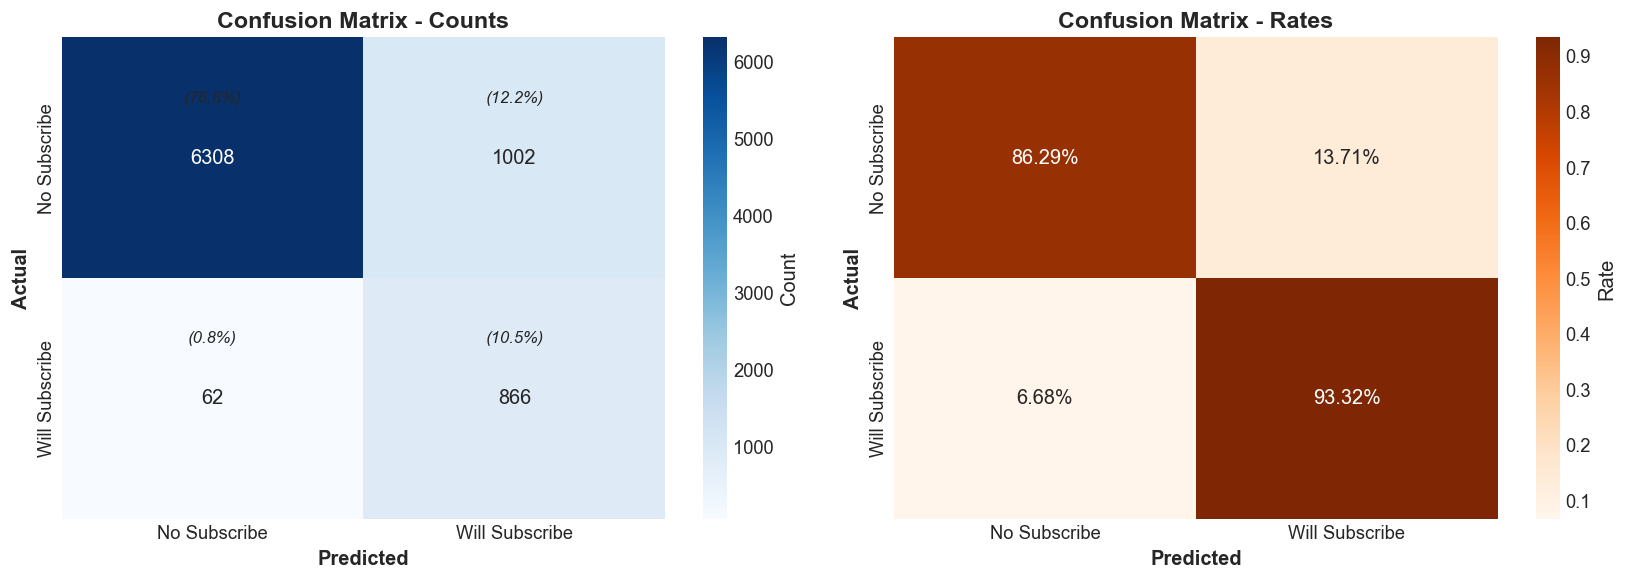

In [29]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")


cm = confusion_matrix(y_test, y_pred)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No Subscribe', 'Will Subscribe'],
            yticklabels=['No Subscribe', 'Will Subscribe'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix - Counts', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted', fontweight='bold')
ax1.set_ylabel('Actual', fontweight='bold')

for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / np.sum(cm) * 100
        ax1.text(j+0.5, i+0.25, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, style='italic')


cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Oranges', ax=ax2,
            xticklabels=['No Subscribe', 'Will Subscribe'],
            yticklabels=['No Subscribe', 'Will Subscribe'],
            cbar_kws={'label': 'Rate'})
ax2.set_title('Confusion Matrix - Rates', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted', fontweight='bold')
ax2.set_ylabel('Actual', fontweight='bold')

plt.tight_layout()
plt.show()

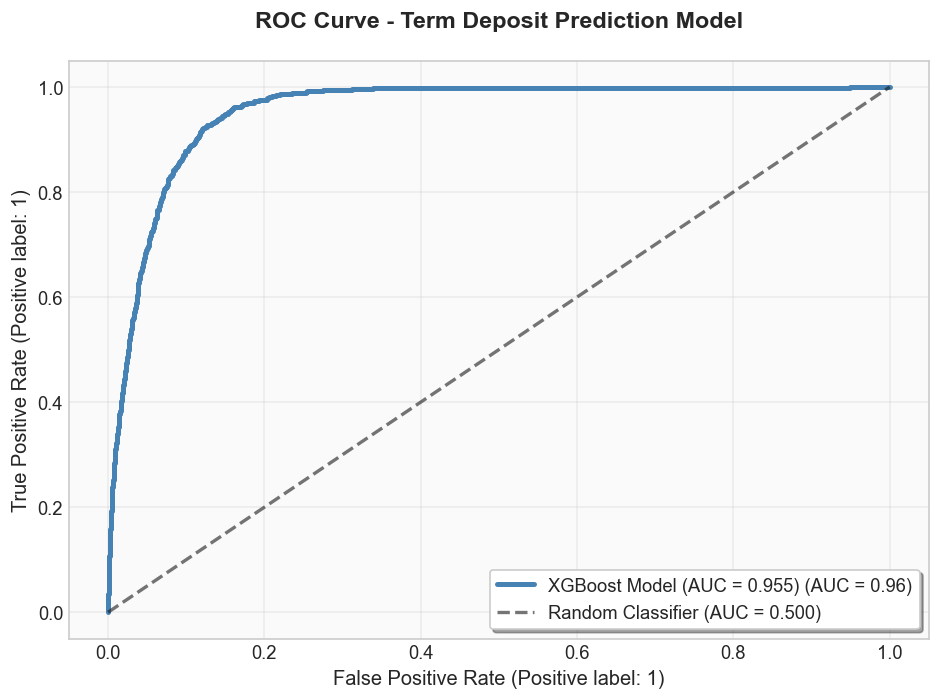

In [33]:
plt.style.use('seaborn-v0_8-whitegrid')


fig, ax = plt.subplots(1, 1, figsize=(8, 6))


roc_display = RocCurveDisplay.from_predictions(
    y_test, y_proba, ax=ax, 
    name=f'XGBoost Model (AUC = {roc_auc_score(y_test, y_proba):.3f})',
    color='steelblue', linewidth=3
)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=2, 
        label='Random Classifier (AUC = 0.500)')

ax.set_title('ROC Curve - Term Deposit Prediction Model', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3)
ax.set_facecolor('#fafafa')

plt.tight_layout()
plt.show()

In [35]:
joblib.dump(pipe, "models/xgb_pipeline.pkl")
joblib.dump(preprocessor, "models/preprocessor.pkl")
print("Models are saved sucessfully")

Models are saved sucessfully
